In [1]:
%matplotlib inline
import os
import sys
import numpy
from pandas import DataFrame
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
#from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix, f1_score

def progress(i, end_val, bar_length=50):
    '''
    Print a progress bar of the form: Percent: [#####      ]
    i is the current progress value expected in a range [0..end_val]
    bar_length is the width of the progress bar on the screen.
    '''
    percent = float(i) / end_val
    hashes = '#' * int(round(percent * bar_length))
    spaces = ' ' * (bar_length - len(hashes))
    sys.stdout.write("\rPercent: [{0}] {1}%".format(hashes + spaces, int(round(percent * 100))))
    sys.stdout.flush()

NEWLINE = '\n'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloadin

True

In [4]:
# Needed for Lingustic Analysis
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# We will visualize the messages with a word cloud
from wordcloud import WordCloud


# Multinomial Naive Bayes Classifier
from sklearn.naive_bayes import MultinomialNB

# Import Tf-idf Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Import the Label Encoder
from sklearn.preprocessing import LabelEncoder

# Import the train test split
from sklearn.model_selection import train_test_split

# To evaluate our model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
HAM = 'ham'
SPAM = 'spam'

SOURCES = [
    ('/content/gdrive/MyDrive/data2/lokay-m',      HAM),
    ('/content/gdrive/MyDrive/data2/BG',    SPAM),
    
]

SKIP_FILES = {'cmds'}


def read_files(path):
    '''
    Generator of pairs (filename, filecontent)
    for all files below path whose name is not in SKIP_FILES.
    The content of the file is of the form:
        header....
        <emptyline>
        body...
    This skips the headers and returns body only.
    '''
    for root, dir_names, file_names in os.walk(path):
        for path in dir_names:
            read_files(os.path.join(root, path))
        for file_name in file_names:
            if file_name not in SKIP_FILES:
                file_path = os.path.join(root, file_name)
                if os.path.isfile(file_path):
                    past_header, lines = False, []
                    f = open(file_path, encoding="latin-1")
                    for line in f:
                        if past_header:
                            lines.append(line)
                        elif line == NEWLINE:
                            past_header = True
                    f.close()
                    content = NEWLINE.join(lines)
                    yield file_path, content


def build_data_frame(l, path, classification):
    rows = []
    index = []
    for i, (file_name, text) in enumerate(read_files(path)):
        if ((i+l) % 100 == 0):
            progress(i+l, 58910, 50)
        rows.append({'text': text, 'class': classification})
        index.append(file_name)
   
    data_frame = DataFrame(rows, index=index)
    return data_frame, len(rows)

def load_data():
    data = DataFrame({'text': [], 'class': []})
    l = 0
    for path, classification in SOURCES:
        data_frame, nrows = build_data_frame(l, path, classification)
        data = data.append(data_frame)
        l += nrows
    data = data.reindex(numpy.random.permutation(data.index))
    return data

In [7]:
# This should take about 2 minutes
data=load_data()

Percent: [##########                                        ] 21%

In [8]:
len(data)

12368

In [11]:
data.dropna(subset = ["text"], inplace=True)
# Display firt five rows
display(data.head())

# Display the summary statistics
display(data.describe())

# Print the info
print(data.info())

,text,class
/content/gdrive/MyDrive/data2/lokay-m/enron_travel_club/39,Please see attached announcement on The Lion K...,ham
/content/gdrive/MyDrive/data2/BG/2005/04/1113622200.26885_15.txt,"Dear Homeowner,\n\n\n\nDid you know you can re...",spam
/content/gdrive/MyDrive/data2/lokay-m/tw_commercial_group/150,Attached for your convenience find the latest ...,ham
/content/gdrive/MyDrive/data2/BG/2005/05/1115611356.15591_14.txt,<HTML>\n\nFlnd a better alternative that can h...,spam
/content/gdrive/MyDrive/data2/lokay-m/tw_commercial_group/875,"Jill, I need to revise one of the guarantees t...",ham


,text,class
count,12368,12368
unique,11016,2
top,,spam
freq,11,10003


<class 'pandas.core.frame.DataFrame'>
Index: 12368 entries, /content/gdrive/MyDrive/data2/lokay-m/enron_travel_club/39 to /content/gdrive/MyDrive/data2/BG/2005/03/1111083373.21951_799.txt
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    12368 non-null  object
 1   class   12368 non-null  object
dtypes: object(2)
memory usage: 289.9+ KB
None


spam    0.808781
ham     0.191219
Name: class, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


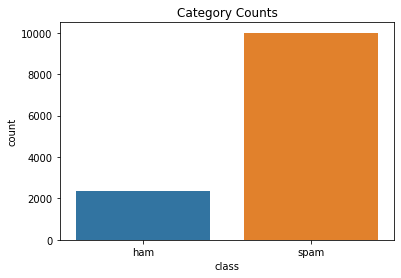

In [14]:
# Print the counts of each category
#print(data['Spam/Ham'].value_counts())

# Print the proportions of each category
print(data['class'].value_counts(normalize=True))

# Visualize the Categories
sns.countplot(data['class'])
plt.title("Category Counts")
plt.show()

In [13]:
# Initialize the Label Encoder.
le = LabelEncoder()

# Encode the categories
data['Category_enc'] = le.fit_transform(data['class'])

# Display the first five rows again to see the result
display(data.head())

# Print the datatypes
print(data.dtypes)

,text,class,Category_enc
/content/gdrive/MyDrive/data2/lokay-m/enron_travel_club/39,Please see attached announcement on The Lion K...,ham,0
/content/gdrive/MyDrive/data2/BG/2005/04/1113622200.26885_15.txt,"Dear Homeowner,\n\n\n\nDid you know you can re...",spam,1
/content/gdrive/MyDrive/data2/lokay-m/tw_commercial_group/150,Attached for your convenience find the latest ...,ham,0
/content/gdrive/MyDrive/data2/BG/2005/05/1115611356.15591_14.txt,<HTML>\n\nFlnd a better alternative that can h...,spam,1
/content/gdrive/MyDrive/data2/lokay-m/tw_commercial_group/875,"Jill, I need to revise one of the guarantees t...",ham,0


text            object
class           object
Category_enc     int64
dtype: object


class
ham     236.115856
spam    308.641608
Name: word_count, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


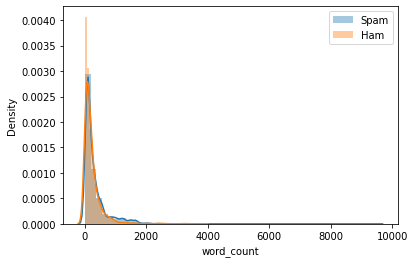

In [15]:
# Store the number of words in each messages
data['word_count'] = data['text'].str.split().str.len()

# Print the average number of words in each category
print(data.groupby('class')['word_count'].mean())

# Visualize the distribution of word counts in each category
sns.distplot(data[data['class']=='spam']['word_count'], label='Spam')
sns.distplot(data[data['class']=='ham']['word_count'], label='Ham'),
plt.legend()
plt.show()

In [16]:
# Make the letters lower case and tokenize the words
tokenized_messages = data['text'].str.lower().apply(word_tokenize)

# Print the tokens to see how it looks like
print(tokenized_messages)

/content/gdrive/MyDrive/data2/lokay-m/enron_travel_club/39           [please, see, attached, announcement, on, the,...
/content/gdrive/MyDrive/data2/BG/2005/04/1113622200.26885_15.txt     [dear, homeowner, ,, did, you, know, you, can,...
/content/gdrive/MyDrive/data2/lokay-m/tw_commercial_group/150        [attached, for, your, convenience, find, the, ...
/content/gdrive/MyDrive/data2/BG/2005/05/1115611356.15591_14.txt     [<, html, >, flnd, a, better, alternative, tha...
/content/gdrive/MyDrive/data2/lokay-m/tw_commercial_group/875        [jill, ,, i, need, to, revise, one, of, the, g...
                                                                                           ...                        
/content/gdrive/MyDrive/data2/BG/2005/05/1116367512.8154_1203.txt    [--, --, 9612061649.265943346164959.06934, con...
/content/gdrive/MyDrive/data2/BG/2005/01/1106786390.6600_1130.txt    [roberts, ,, breaking, news, alert, emerson, 0...
/content/gdrive/MyDrive/data2/BG/2005/07/1120680

In [17]:
# Define a function to returns only alphanumeric tokens
def alpha(tokens):
    """This function removes all non-alphanumeric characters"""
    alpha = []
    for token in tokens:
        if str.isalpha(token) or token in ['n\'t','won\'t']:
            if token=='n\'t':
                alpha.append('not')
                continue
            elif token == 'won\'t':
                alpha.append('wont')
                continue
            alpha.append(token)
    return alpha

# Apply our function to tokens
tokenized_messages = tokenized_messages.apply(alpha)

print(tokenized_messages)

/content/gdrive/MyDrive/data2/lokay-m/enron_travel_club/39           [please, see, attached, announcement, on, the,...
/content/gdrive/MyDrive/data2/BG/2005/04/1113622200.26885_15.txt     [dear, homeowner, did, you, know, you, can, re...
/content/gdrive/MyDrive/data2/lokay-m/tw_commercial_group/150        [attached, for, your, convenience, find, the, ...
/content/gdrive/MyDrive/data2/BG/2005/05/1115611356.15591_14.txt     [html, flnd, a, better, alternative, that, can...
/content/gdrive/MyDrive/data2/lokay-m/tw_commercial_group/875        [jill, i, need, to, revise, one, of, the, guar...
                                                                                           ...                        
/content/gdrive/MyDrive/data2/BG/2005/05/1116367512.8154_1203.txt    [similar, similar, turning, make, supposedto, ...
/content/gdrive/MyDrive/data2/BG/2005/01/1106786390.6600_1130.txt    [roberts, breaking, news, alert, emerson, and,...
/content/gdrive/MyDrive/data2/BG/2005/07/1120680

In [18]:
# Define a function to remove stop words
def remove_stop_words(tokens):
    """This function removes all stop words in terms of nltk stopwords"""
    no_stop = []
    for token in tokens:
        if token not in stopwords.words('english'):
            no_stop.append(token)
    return no_stop

# Apply our function to tokens
tokenized_messages = tokenized_messages.apply(remove_stop_words)

print(tokenized_messages)

/content/gdrive/MyDrive/data2/lokay-m/enron_travel_club/39           [please, see, attached, announcement, lion, ki...
/content/gdrive/MyDrive/data2/BG/2005/04/1113622200.26885_15.txt     [dear, homeowner, know, refinance, current, ra...
/content/gdrive/MyDrive/data2/lokay-m/tw_commercial_group/150        [attached, convenience, find, latest, drafts, ...
/content/gdrive/MyDrive/data2/BG/2005/05/1115611356.15591_14.txt     [html, flnd, better, alternative, help, sav, l...
/content/gdrive/MyDrive/data2/lokay-m/tw_commercial_group/875        [jill, need, revise, one, guarantees, forwarde...
                                                                                           ...                        
/content/gdrive/MyDrive/data2/BG/2005/05/1116367512.8154_1203.txt    [similar, similar, turning, make, supposedto, ...
/content/gdrive/MyDrive/data2/BG/2005/01/1106786390.6600_1130.txt    [roberts, breaking, news, alert, emerson, gas,...
/content/gdrive/MyDrive/data2/BG/2005/07/1120680

In [19]:
# Define a function to lemmatization
def lemmatize(tokens):
    """This function lemmatize the messages"""
    # Initialize the WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    # Create the lemmatized list
    lemmatized = []
    for token in tokens:
            # Lemmatize and append
            lemmatized.append(lemmatizer.lemmatize(token))
    return " ".join(lemmatized)

# Apply our function to tokens
tokenized_messages = tokenized_messages.apply(lemmatize)

print(tokenized_messages)

/content/gdrive/MyDrive/data2/lokay-m/enron_travel_club/39           please see attached announcement lion king jon...
/content/gdrive/MyDrive/data2/BG/2005/04/1113622200.26885_15.txt     dear homeowner know refinance current rate muc...
/content/gdrive/MyDrive/data2/lokay-m/tw_commercial_group/150        attached convenience find latest draft transpo...
/content/gdrive/MyDrive/data2/BG/2005/05/1115611356.15591_14.txt     html flnd better alternative help sav lot rnon...
/content/gdrive/MyDrive/data2/lokay-m/tw_commercial_group/875        jill need revise one guarantee forwarded date ...
                                                                                           ...                        
/content/gdrive/MyDrive/data2/BG/2005/05/1116367512.8154_1203.txt    similar similar turning make supposedto happen...
/content/gdrive/MyDrive/data2/BG/2005/01/1106786390.6600_1130.txt    robert breaking news alert emerson gas domesti...
/content/gdrive/MyDrive/data2/BG/2005/07/1120680

In [20]:
# Replace the columns with tokenized messages
data['text'] = tokenized_messages

# Display the first five rows
display(data.head(10))

,text,class,Category_enc,word_count
/content/gdrive/MyDrive/data2/lokay-m/enron_travel_club/39,please see attached announcement lion king jon...,ham,0,23
/content/gdrive/MyDrive/data2/BG/2005/04/1113622200.26885_15.txt,dear homeowner know refinance current rate muc...,spam,1,60
/content/gdrive/MyDrive/data2/lokay-m/tw_commercial_group/150,attached convenience find latest draft transpo...,ham,0,57
/content/gdrive/MyDrive/data2/BG/2005/05/1115611356.15591_14.txt,html flnd better alternative help sav lot rnon...,spam,1,192
/content/gdrive/MyDrive/data2/lokay-m/tw_commercial_group/875,jill need revise one guarantee forwarded date ...,ham,0,155
/content/gdrive/MyDrive/data2/BG/2005/04/1113422321.3013_151.txt,stock watch morning wysak petroleum wysk key e...,spam,1,535
/content/gdrive/MyDrive/data2/BG/2005/03/1111815492.4778_38.txt,experience convenient support quick response s...,spam,1,127
/content/gdrive/MyDrive/data2/lokay-m/tw_commercial_group/1601,new well phillip completed panhandle appears c...,ham,0,89
/content/gdrive/MyDrive/data2/BG/2005/04/1114489501.26962_13.txt,see blithe spirit around mean power drill behi...,spam,1,325
/content/gdrive/MyDrive/data2/BG/2004/12/1103215449.9812_809.txt,message mime format doctype html public html h...,spam,1,283


In [21]:
# Select the features and the target
X = data['text']
y = data['Category_enc']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34, stratify=y)

In [23]:
# Create the tf-idf vectorizer
vectorizer = TfidfVectorizer(strip_accents='ascii')
#x = vectorizer.fit_transform(df['Message'].values.astype('U'))
# First fit the vectorizer with our training set
tfidf_train = vectorizer.fit_transform(X_train)

# Now we can fit our test data with the same vectorizer
tfidf_test = vectorizer.transform(X_test)

In [24]:
from sklearn.naive_bayes import MultinomialNB

nb =MultinomialNB()
nb.fit(tfidf_train, y_train)
print("Accuracy:",nb.score(tfidf_test, y_test))

Accuracy: 0.9470493128536782


In [25]:
predictions = nb.predict(tfidf_test)
cr = classification_report(predictions, y_test)
print(cr)

              precision    recall  f1-score   support

           0       0.72      1.00      0.84       342
           1       1.00      0.94      0.97      2132

    accuracy                           0.95      2474
   macro avg       0.86      0.97      0.90      2474
weighted avg       0.96      0.95      0.95      2474

